In [1]:
import json 
import pandas as pd
import numpy as np
import re
from datetime import datetime
import seaborn as sns

## import data

In [2]:
data = []    
with open("json/to-20200629.json", errors='ignore') as f:
    for line in f.readlines():
        try: 
            data.append(json.loads(line))
        except: 
            pass

## data processing

In [32]:
df = pd.DataFrame(data, columns = ['text','retweet_count','favorite_count','id','user','in_reply_to_status_id_str', 'quoted_status_id_str'])

# get user info from users field
column = ['description','screen_name','name','followers_count','statuses_count','favourites_count','created_at', 'entities','following']
for c in column:
    df[c] = df['user'].apply(lambda x: x[c])

# get harmony url from entities
df['harmony-url'] = df['entities'].apply(lambda x: x["url"]["urls"][0]["expanded_url"] if 'url' in x else (x['description']["urls"][0]["expanded_url"] if "description" in x and x['description']['urls'] else ""))    
df.drop(['user','entities'], axis=1, inplace = True)
# create the retweet link for query
df['retweet_link'] = df.apply(lambda c: "https://twitter.com/{}/status/{}".format(c['screen_name'],c['id']), axis = 1)

# change create time to datetime type
df['created_at'] = df['created_at'].apply(lambda c: datetime.strptime(c,'%a %b %d %H:%M:%S +0000 %Y'))

df.drop(['id'], axis = 1, inplace=True)

In [59]:
df['harmony-url'] = df['entities'].apply(lambda x: x["url"]["urls"][0]["expanded_url"] if 'url' in x else (x['description']["urls"][0]["expanded_url"] if "description" in x and x['description']['urls'] else ""))  

### - original 10399 data

In [4]:
df.shape

(10399, 15)

### - filter only June pow related twitter

In [5]:
df['reply_pow_flag'] = df['in_reply_to_status_id_str'].apply(lambda c: True if not c \
                                                   or c == '1276552098402889731' \
                                                   else False)

 
df = df[df['reply_pow_flag']] 
df['quote_pow_flag'] = df['quoted_status_id_str'].apply(lambda c: True if np.isnan(float(c)) \
                                                         or c == '1276552098402889731' \
                                                         else False)
df = df[df['quote_pow_flag']] 

### - filter the original writer who retweets/reply with comments 

In [6]:
df['RT_flag'] = df['text'].apply(lambda c: True if "RT" in c else False)
comment_df = df[df['RT_flag'] == False]

### - filter those with correct harmony-link 
- http://harmony.one/#[NAME]=[ONE-address] 
- https://harmony.one/#[NAME]=[ONE-address]

In [7]:
pattern = re.compile('.*?\/#.*?=one.*?')
comment_df['hmy-url-flag'] = comment_df['harmony-url'].apply(lambda c: True if re.match(pattern, c) else False)
filter_df = comment_df[comment_df['hmy-url-flag']]
filter_df.drop(['RT_flag','hmy-url-flag', 'quote_pow_flag','reply_pow_flag'], axis=1, inplace = True)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### - filter followers 100+ retweet > 0

In [8]:
filter_df = filter_df[(filter_df['followers_count'] >= 100) & (filter_df['retweet_count'] > 0)]
filter_df.reset_index(drop = True, inplace = True)

## Statisc summary of the filter result
- 129 unique users satisfied reward
- among those 15 are following by stephen
- max retweet 206

In [16]:
len(filter_df['screen_name'].unique())

129

In [9]:
filter_df.describe()

,retweet_count,favorite_count,followers_count,statuses_count,favourites_count
count,132.000000,132.000000,132.000000,132.000000,132.000000
mean,25.484848,20.924242,547.151515,3150.219697,2561.742424
std,35.832623,27.604519,1046.829335,10248.485268,6907.880526
min,1.000000,0.000000,100.000000,14.000000,1.000000
25%,3.000000,4.000000,131.750000,336.750000,210.750000
50%,12.000000,11.000000,192.000000,724.500000,510.500000
75%,33.000000,24.000000,511.750000,2173.500000,1935.250000
max,206.000000,159.000000,8486.000000,106011.000000,48848.000000


In [10]:
len(filter_df[filter_df['following']])

15

## Histogram of retweet counts
- 6 ppl > 100 retweets
- 23 ppl > 50 retweets

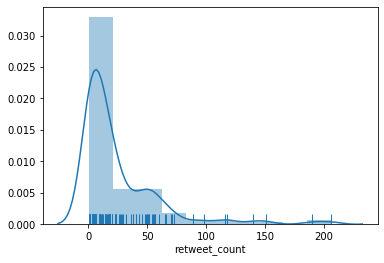

In [11]:
sns.distplot(filter_df['retweet_count'], bins=10, rug=True)

### - retweets 100 +

In [12]:
filter_df[filter_df['retweet_count'] > 100][['text','retweet_count','name','created_at','following']]

,text,retweet_count,name,created_at,following
13,@stse @cz_binance @HuobiGlobal @AtomicWallet C...,206,Kim Abrahan 🇵🇭 $SLNS,2019-09-19 01:19:38,False
34,@stse\nHarmony introduced Harmony Angels - Rad...,118,Jignesh Beladiya,2010-06-25 05:15:42,False
37,@stse @cz_binance @HuobiGlobal @AtomicWallet J...,140,✨🔥✨ RENGGA ✨🔥✨,2019-10-26 10:57:17,False
43,@stse @cz_binance @HuobiGlobal @AtomicWallet #...,116,Kasurganteng,2018-11-17 01:58:58,False
121,@stse @cz_binance @HuobiGlobal @AtomicWallet #...,190,Pratama raka,2013-05-19 14:57:17,False
131,@stse\nOur mission is to scale trust for billi...,151,Zunaidi Munandar Siregar,2018-07-26 00:45:47,True


In [13]:
check_df = filter_df[filter_df['retweet_count'] > 100]
for i in range(len(check_df)):
    print(check_df.iloc[i]['retweet_link'])

https://twitter.com/cabs_kim/status/1276875338971090946
https://twitter.com/jigneshon/status/1276765382196506624
https://twitter.com/jonospirit/status/1276737190932799493
https://twitter.com/Kasurganteng/status/1276711848096624644
https://twitter.com/pra_rakapratama/status/1276553640963002368
https://twitter.com/MunandarZunaidi/status/1276446873528578048


### - retweets 50+ 

In [21]:
len(filter_df[filter_df['retweet_count'] > 50])

23

In [57]:
check_df = filter_df[(filter_df['retweet_count'] > 50)]
for i in range(len(check_df)):
    print(check_df.iloc[i]['retweet_link'])

https://twitter.com/cabs_kim/status/1276875338971090946
https://twitter.com/Ilhamak15659158/status/1276784200041951232
https://twitter.com/bhaktidas108/status/1276780194393702401
https://twitter.com/jigneshon/status/1276765382196506624
https://twitter.com/dukuncoin/status/1276740731512578050
https://twitter.com/jonospirit/status/1276737190932799493
https://twitter.com/Angkasah09/status/1276733666723389441
https://twitter.com/Kasurganteng/status/1276711848096624644
https://twitter.com/agli_chandra/status/1276687486903660549
https://twitter.com/fandiyusuf_710/status/1276594041094729729
https://twitter.com/ahsanedge/status/1276587250545909761
https://twitter.com/stse/status/1276584018998222849
https://twitter.com/Lastri43468297/status/1276582893821636609
https://twitter.com/salmanmbstu96/status/1276566320377556993
https://twitter.com/dee_jick/status/1276557906549207041
https://twitter.com/NurulHasikin17/status/1276554366279839745
https://twitter.com/Cryptotest14/status/1276554319756775425

### - retweets 50+ and followed by stephen

In [22]:
filter_df[(filter_df['retweet_count'] > 50) & (filter_df['following'])][['text','retweet_count','name','created_at','following']]

,text,retweet_count,name,created_at,following
66,@stse @cz_binance @HuobiGlobal @AtomicWallet #...,51,F🅰ndy,2012-07-19 08:18:32,True
72,we've reserved vanity url https://t.co/TYUtTLS...,89,stephen tse,2008-03-06 00:46:35,True
131,@stse\nOur mission is to scale trust for billi...,151,Zunaidi Munandar Siregar,2018-07-26 00:45:47,True


In [23]:
check_df = filter_df[(filter_df['retweet_count'] > 50) & (filter_df['following'])]
for i in range(len(check_df)):
    print(check_df.iloc[i]['retweet_link'])

https://twitter.com/fandiyusuf_710/status/1276594041094729729
https://twitter.com/stse/status/1276584018998222849
https://twitter.com/MunandarZunaidi/status/1276446873528578048


### - retweets 10+ and followed by stephen

In [14]:
filter_df[(filter_df['retweet_count'] > 10) & (filter_df['following'])][['text','retweet_count','name','created_at','following']]

,text,retweet_count,name,created_at,following
61,@stse @cz_binance @HuobiGlobal @AtomicWallet J...,18,Ganesha Upadhyaya,2011-02-10 01:02:30,True
66,@stse @cz_binance @HuobiGlobal @AtomicWallet #...,51,F🅰ndy,2012-07-19 08:18:32,True
72,we've reserved vanity url https://t.co/TYUtTLS...,89,stephen tse,2008-03-06 00:46:35,True
100,@stse @cz_binance @HuobiGlobal @AtomicWallet @...,38,Mach G,2017-04-25 14:38:20,True
131,@stse\nOur mission is to scale trust for billi...,151,Zunaidi Munandar Siregar,2018-07-26 00:45:47,True


In [25]:
check_df = filter_df[(filter_df['retweet_count'] > 10) & (filter_df['following'])]
for i in range(len(check_df)):
    print(check_df.iloc[i]['retweet_link'])

https://twitter.com/gupadhyaya/status/1276632268958662656
https://twitter.com/fandiyusuf_710/status/1276594041094729729
https://twitter.com/stse/status/1276584018998222849
https://twitter.com/theartistmsg/status/1276562341111517192
https://twitter.com/MunandarZunaidi/status/1276446873528578048


## check the user create time 
- newest created at 2020-06-19
- seems normal 

In [15]:
time_df = filter_df.sort_values(by= ['created_at'], ascending = False)
time_df[['text','retweet_count','name','created_at']].head(5)

,text,retweet_count,name,created_at
123,@stse @cz_binance @HuobiGlobal @AtomicWallet #...,1,Cryptono,2020-06-19 16:03:17
128,@stse\n\n#Pow\n#Pow20\nverry nice Wow best pro...,98,meymeymi,2020-05-30 10:35:10
8,@stse @cz_binance @HuobiGlobal @AtomicWallet C...,6,Mikoto Miyuki,2020-05-26 21:08:54
33,@stse @cz_binance @HuobiGlobal @AtomicWallet J...,1,saman kumara,2020-05-22 19:22:40
5,@stse @cz_binance @HuobiGlobal @AtomicWallet #...,6,ZakiraCrypt,2020-05-09 09:00:40


## filter the users who comment/retweet more than once
- when we are rewarding, should we only reward once or based on the sum of the reweet?

In [17]:
user = filter_df.groupby(['screen_name'])['screen_name'].count().reset_index(name = 'count')
filter_user = user[user['count'] > 1]
filter_user.sort_values(by = ['count'],ascending = False)

,screen_name,count
70,aroluyo,2
73,bitkingkong81,2
108,mumet011,2


In [19]:
filter_df['duplicate_user_flag'] = filter_df['screen_name'].apply(lambda x: True if x in filter_user['screen_name'].tolist() else False)
duplicate_user_df = filter_df[filter_df['duplicate_user_flag']]
duplicate_retweet = duplicate_user_df.groupby(['screen_name'])['retweet_count'].sum().reset_index()
duplicate_retweet.sort_values(by = ['retweet_count'],ascending = False)


,screen_name,retweet_count
0,aroluyo,25
1,bitkingkong81,15
2,mumet011,9


In [20]:
name_list = duplicate_retweet['screen_name'].tolist()
for name in name_list:
    index = filter_df[filter_df['screen_name'] == name].index
    for i in index:
        print(filter_df.iloc[i]['retweet_link'])

https://twitter.com/aroluyo/status/1276681398020116482
https://twitter.com/aroluyo/status/1276669654707077126
https://twitter.com/bitkingkong81/status/1276838620557537281
https://twitter.com/bitkingkong81/status/1276836733733072902
https://twitter.com/mumet011/status/1276601751806701568
https://twitter.com/mumet011/status/1276560858370301959
